# Modelo RNN Sin Memoria (Simple RNN)

En este cuaderno se implementa una Red Neuronal Recurrente (RNN) básica (sin celdas de memoria compleja como LSTM o GRU) para la clasificación de texto.
El objetivo es entrenar y evaluar el modelo utilizando los embeddings pre-procesados.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score

# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## Carga y Preprocesamiento de Datos

Se cargan los archivos `.npy` que contienen los embeddings y las etiquetas.
Los datos de entrada tienen la forma `(N, 384)`. Para utilizarlos en una RNN, los redimensionamos a `(N, 1, 384)`, tratando cada embedding como una secuencia de longitud 1.
Las etiquetas se ajustan para iniciar en 0 (de 1-5 a 0-4).

In [4]:
# Cargar datos
train_X = np.load('train_all.npy')
train_y = np.load('train_labels.npy')
valid_X = np.load('valid_all.npy')
valid_y = np.load('valid_labels.npy')
test_X = np.load('test_all.npy')
test_y = np.load('test_labels.npy')

# Convertir a tensores de PyTorch
# Redimensionar X a (Batch, Sequence Length, Features) -> (N, 1, 384)
X_train_tensor = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(train_y - 1, dtype=torch.long).to(device) # Restar 1 para que las clases sean 0-4

X_valid_tensor = torch.tensor(valid_X, dtype=torch.float32).unsqueeze(1).to(device)
y_valid_tensor = torch.tensor(valid_y - 1, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(test_X, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(test_y - 1, dtype=torch.long).to(device)

print(f"Forma de X_train: {X_train_tensor.shape}")
print(f"Forma de y_train: {y_train_tensor.shape}")

# Crear DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Forma de X_train: torch.Size([1200000, 1, 384])
Forma de y_train: torch.Size([1200000])


## Modelo RNN Sin Memoria Optimizado

Aunque las RNN simples tienen limitaciones para retener información a largo plazo, podemos mejorar su rendimiento significativamente utilizando:
- **Bidireccionalidad**: Permite a la red ver el contexto futuro y pasado (aunque con seq_len=1 esto es menos relevante, pero útil si aumentamos la secuencia).
- **Múltiples Capas (Stacked RNN)**: Aumenta la capacidad de abstracción del modelo.
- **Dropout y Batch Normalization**: Ayudan a regularizar y estabilizar el entrenamiento.
- **Mayor Hidden Size**: Para capturar más características de los embeddings.

In [11]:
class OptimizedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(OptimizedRNNModel, self).__init__()
        
        # Bidirectional=True duplica el tamaño de la salida oculta
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, 
                          batch_first=True, dropout=dropout, bidirectional=True)
        
        # BatchNorm para la salida de la RNN (hidden_size * 2 por bidireccional)
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        
        self.dropout = nn.Dropout(dropout)
        
        # Capa lineal final
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, h_n = self.rnn(x)
        
        # out: (batch, seq_len, hidden_size * 2)
        # Tomamos el último paso de tiempo
        last_out = out[:, -1, :]
        
        last_out = self.bn(last_out)
        last_out = self.dropout(last_out)
        
        out = self.fc(last_out)
        return out

# Instanciar el modelo optimizado
input_size = 384
hidden_size = 256
output_size = 5
num_layers = 2
dropout = 0.3

model_opt = OptimizedRNNModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
print("Modelo RNN Optimizado:")
print(model_opt)

Modelo RNN Optimizado:
OptimizedRNNModel(
  (rnn): RNN(384, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)


## Entrenamiento Avanzado (RNN Optimizado)

Se aplica el mismo esquema de entrenamiento robusto que en el modelo LSTM:
- **Early Stopping** (Paciencia = 5).
- **Model Checkpointing** (Guardar `best_rnn_model.pth`).
- **ReduceLROnPlateau**.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_opt.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

num_epochs = 20
best_valid_acc = 0.0
patience = 5
patience_counter = 0

# Listas para historial
train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []

print("Iniciando entrenamiento del modelo optimizado...")

for epoch in range(num_epochs):
    model_opt.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_opt(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
        
    train_acc = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    
    # Validación
    model_opt.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = model_opt(X_batch)
            loss = criterion(outputs, y_batch)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += y_batch.size(0)
            correct_valid += (predicted == y_batch).sum().item()
            
    valid_acc = 100 * correct_valid / total_valid
    avg_valid_loss = valid_loss / len(valid_loader)
    
    # Guardar métricas
    train_loss_history.append(avg_train_loss)
    valid_loss_history.append(avg_valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
    
    scheduler.step(avg_valid_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_opt.state_dict(), 'best_rnn_model.pth')
        print(f"--> Mejor modelo guardado con Acc: {valid_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print("Early stopping activado.")
        break

print("Entrenamiento finalizado.")

Iniciando entrenamiento del modelo optimizado...
Epoch [1/20] Train Loss: 1.1382, Train Acc: 49.77% | Valid Loss: 1.0938, Valid Acc: 52.08%
--> Mejor modelo guardado con Acc: 52.08%
Epoch [1/20] Train Loss: 1.1382, Train Acc: 49.77% | Valid Loss: 1.0938, Valid Acc: 52.08%
--> Mejor modelo guardado con Acc: 52.08%
Epoch [2/20] Train Loss: 1.1060, Train Acc: 51.37% | Valid Loss: 1.0839, Valid Acc: 52.32%
--> Mejor modelo guardado con Acc: 52.32%
Epoch [2/20] Train Loss: 1.1060, Train Acc: 51.37% | Valid Loss: 1.0839, Valid Acc: 52.32%
--> Mejor modelo guardado con Acc: 52.32%
Epoch [3/20] Train Loss: 1.0972, Train Acc: 51.76% | Valid Loss: 1.0738, Valid Acc: 53.04%
--> Mejor modelo guardado con Acc: 53.04%
Epoch [4/20] Train Loss: 1.0923, Train Acc: 52.01% | Valid Loss: 1.0713, Valid Acc: 53.11%
--> Mejor modelo guardado con Acc: 53.11%
Epoch [5/20] Train Loss: 1.0883, Train Acc: 52.14% | Valid Loss: 1.0666, Valid Acc: 53.37%
--> Mejor modelo guardado con Acc: 53.37%
Epoch [6/20] Train L

## Visualización de Resultados

Se grafican las curvas de pérdida y precisión para los conjuntos de entrenamiento y validación.

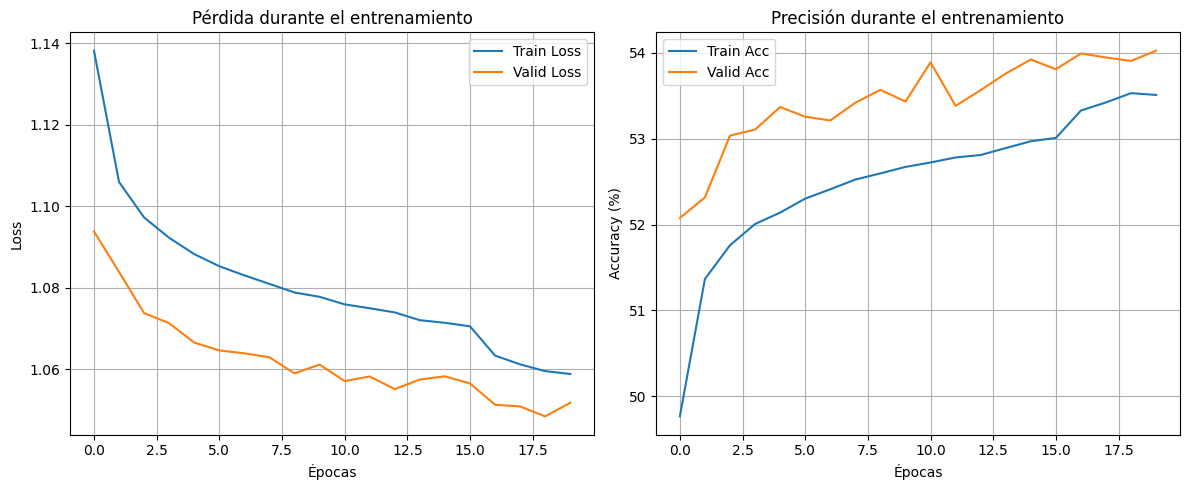

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfica de Precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(valid_acc_history, label='Valid Acc')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluación Modelo Optimizado

Cargamos el mejor modelo guardado y evaluamos en el conjunto de test.

In [20]:
print("Cargando el mejor modelo RNN optimizado...")
model_opt.load_state_dict(torch.load('best_rnn_model.pth'))
model_opt.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_opt(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy (Optimized RNN): {accuracy * 100:.2f}%')

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5']))

Cargando el mejor modelo RNN optimizado...
Test Accuracy (Optimized RNN): 53.82%

Classification Report:
              precision    recall  f1-score   support

     Clase 1       0.64      0.69      0.66      6000
     Clase 2       0.45      0.45      0.45      6000
     Clase 3       0.44      0.39      0.42      6000
     Clase 4       0.47      0.43      0.45      6000
     Clase 5       0.66      0.72      0.69      6000

    accuracy                           0.54     30000
   macro avg       0.53      0.54      0.53     30000
weighted avg       0.53      0.54      0.53     30000

Test Accuracy (Optimized RNN): 53.82%

Classification Report:
              precision    recall  f1-score   support

     Clase 1       0.64      0.69      0.66      6000
     Clase 2       0.45      0.45      0.45      6000
     Clase 3       0.44      0.39      0.42      6000
     Clase 4       0.47      0.43      0.45      6000
     Clase 5       0.66      0.72      0.69      6000

    accuracy      

# Tabla de confusión

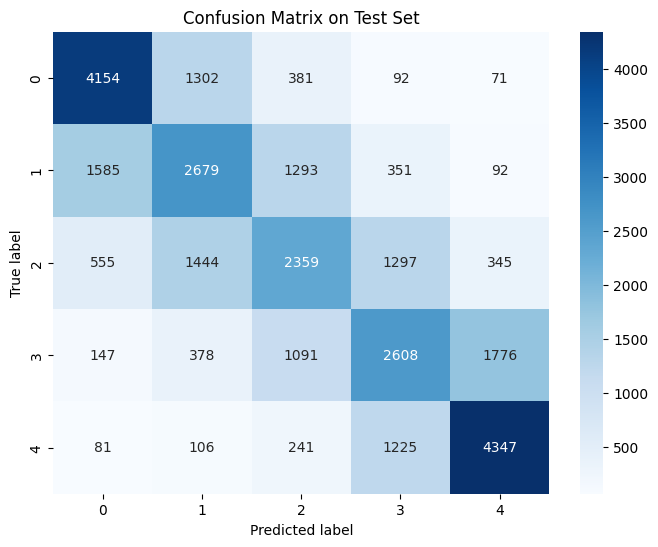

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()